3. (3 points) Improving the FashionMNIST classifier. In the first demo, we trained a simple logistic regression model to classify MNIST digits. Repeat the same experiment, but now use a (dense) neural network with three (3) hidden layers with 256, 128, and 64 neurons respectively, all with ReLU activations. Display train- and test- loss curves, and report test accuracies of your final model. You may have to tweak the total number of training epochs to get reasonable accuracy. Finally, draw any 3 image samples from the test dataset, visualize the predicted class probabilities for each sample, and comment on what you can observe from these plots.

Solution-

In [ ]:
import numpy as np
import torch
import torchvision

In [ ]:
#Getting the FashionMNIST dataset
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 17350500.90it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302463.25it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5523979.69it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13614298.23it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


In [ ]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


torch.Size([28, 28])


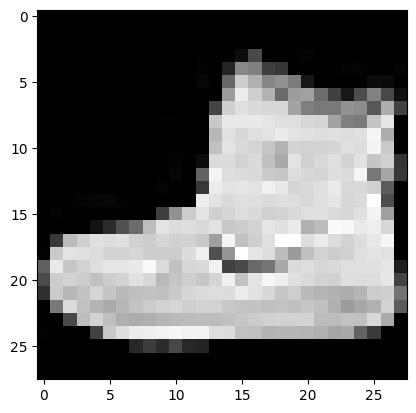

In [ ]:
#Checking the data
print(image.squeeze().shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image.squeeze(), cmap=plt.cm.gray)

In [ ]:
#Loading the data using DataLoader in order to make it efficient
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

In [ ]:
#Verifying the length of the loaded data
print(len(trainDataLoader) * 64) # batch_size from above
print(len(testDataLoader) * 64)

60032
10048


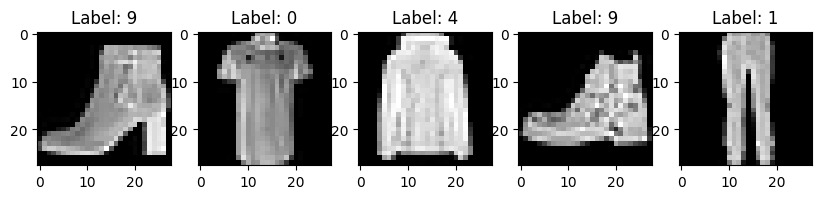

In [ ]:
#Checking how the data looks like
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze(),cmap=plt.cm.gray)

In [ ]:
# Checking for availability of CPU or CUDA
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.is_available()
image=image.to(device)
print("image",image.is_cuda)

Using device: cpu
image False


The above print statement shows that we have CPU available and would hence run on that.

We have to create a neural network with 256, 128, and 64 neurons respectively, all with ReLU activations. Therefore ur network has different layers - first hidden layer has 256 nodes and is connected to the second hidden layer which has 128 nodes which is further connected to a hidden layer with 64 nodes. Relu is used as the activation function for the hidden layers. The last layer is the output layer which has 10 nodes that represent the 10 class labels.

In [ ]:
#Defining the neural network
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #Flattening the 28*28 image into tensor of length 784
        self.flatten = torch.nn.Flatten()
        # Creating the layers of the neural network
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

The 3 step recipe is -
1. Representation - it is a neural network
2. Measure of goodness - we are using the cross entropy loss function as we have categorical variables
3. Optimizing the model - we are using SGD optimizer with a learning rate of 0.01

In [ ]:
model = NeuralNetwork().to(device) # Representation
loss=torch.nn.CrossEntropyLoss() #2. Measure of goodness
optimizer=torch.optim.SGD(model.parameters(),lr=0.01) #3.Optimizing the model
print(model)
print(loss)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
CrossEntropyLoss()


In [ ]:
train_loss_history = []
test_loss_history = []

# training the model for 20 epochs
for epoch in range(20):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images=images.cpu()
    labels=labels.cpu()
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  model.eval()
  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      images=images.cpu()
      labels=labels.cpu()
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 1.7819251995096836, Test loss 1.0261874035665184
Epoch 1, Train loss 0.8129061895138674, Test loss 0.7497557033399108
Epoch 2, Train loss 0.6646442640501299, Test loss 0.6391484593130221
Epoch 3, Train loss 0.5935777638639722, Test loss 0.6811564689988543
Epoch 4, Train loss 0.5482979146148096, Test loss 0.565602210107123
Epoch 5, Train loss 0.5170701298632348, Test loss 0.5388425007747237
Epoch 6, Train loss 0.49565904925881166, Test loss 0.5121295626755733
Epoch 7, Train loss 0.4738062710237147, Test loss 0.5379782387405444
Epoch 8, Train loss 0.4582294791714469, Test loss 0.48369779565911386
Epoch 9, Train loss 0.4429047410485587, Test loss 0.4738432527727382
Epoch 10, Train loss 0.4305858701499286, Test loss 0.4714879361307545
Epoch 11, Train loss 0.418352536031051, Test loss 0.4740946687710513
Epoch 12, Train loss 0.40847969174321525, Test loss 0.4429735034514385
Epoch 13, Train loss 0.3981113229860375, Test loss 0.4316815262197689
Epoch 14, Train loss 0.389111

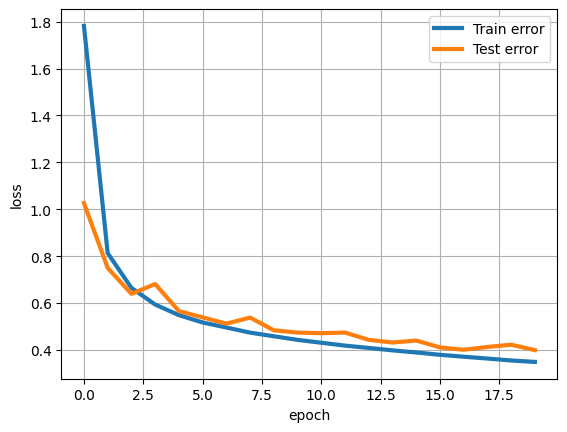

In [ ]:
# plot for loss vs epoch for train and test data
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(20),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Establishing comparison for a small sample dataset
predicted_outputs = model(images)
predicted_classes = torch.max(predicted_outputs, 1)[1]
print('Predicted:', predicted_classes)
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())

Predicted: tensor([3, 1, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
True labels: tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5])
0.1585426926612854


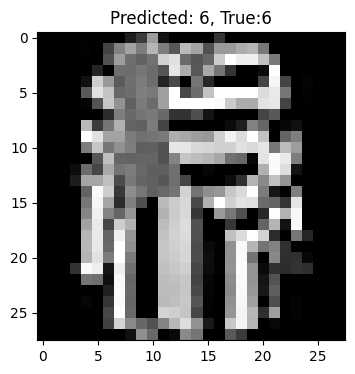

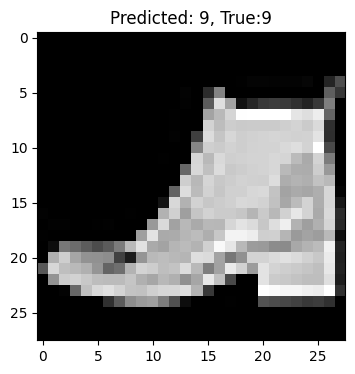

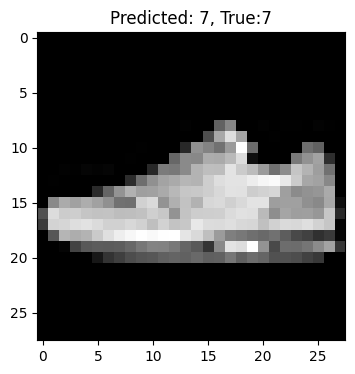

In [ ]:
for i in range(3):
  plt.figure(figsize=(10,4))
  index = np.random.randint(1, 16)
  plt.title(f'Predicted: {predicted_classes[index].item()}, True:{labels[index].item()}')
  plt.imshow(images[index].squeeze().cpu(), cmap = plt.cm.gray)


The above image samples show that the model is predicting correct labels as the predicted and true labels are same.

In [ ]:
#COunting the correct predicted samples
correct=0
correct+=(predicted_classes==labels).float().sum()
print(correct)

tensor(15.)


In [ ]:
# Calculating model accuracy
accuracy=correct/images.shape[0]

In [ ]:
print(accuracy)

tensor(0.9375)


Model has an accuracy of 93.75% which means it is making correct predictions for most of the samples.